# Мониторинг безопасности одиноких пожилых людей

In [56]:
from pathlib import Path
import pickle
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

## Загрузка данных

In [57]:
data_ref_until_2020 = pd.read_csv('../dataset3/DB elder monitoring/data_ref_until_2020-02-13.csv')
data_pos = pd.read_csv('../dataset3/DB elder monitoring/database_pos.csv')
data = pd.read_csv('../dataset3/DB elder monitoring/database_gas.csv')

In [58]:
data["timestamp"] = pd.to_datetime(data["timestamp"]).round('1s').dt.tz_localize(None)

In [59]:
# разметка, из описания понятно какие данные аномальны
ANOMALY_TIME_START = "2020-01-25"
data["anomaly"] = (data["timestamp"] >= ANOMALY_TIME_START).astype(int)
data

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,anomaly
0,2019-11-06 11:37:13,19.48,54.86,128.0,563.0,476.0,731.0,649.0,565.0,128.0,0
1,2019-11-06 11:37:33,19.59,54.23,129.0,563.0,477.0,731.0,649.0,565.0,125.0,0
2,2019-11-06 11:37:53,19.63,54.05,128.0,566.0,478.0,732.0,649.0,565.0,125.0,0
3,2019-11-06 11:38:13,19.64,53.74,128.0,566.0,478.0,732.0,649.0,565.0,125.0,0
4,2019-11-06 11:38:33,19.67,53.53,128.0,569.0,480.0,732.0,650.0,565.0,125.0,0
...,...,...,...,...,...,...,...,...,...,...,...
416148,2020-02-13 11:56:54,20.62,57.75,62.0,518.0,524.0,698.0,642.0,591.0,157.0,1
416149,2020-02-13 11:57:14,20.62,57.75,62.0,518.0,524.0,698.0,641.0,591.0,157.0,1
416150,2020-02-13 11:57:34,20.62,57.75,62.0,518.0,524.0,698.0,641.0,591.0,157.0,1
416151,2020-02-13 11:57:54,20.62,57.74,63.0,518.0,524.0,698.0,641.0,591.0,157.0,1


In [60]:
data_hour_agg = data.groupby(pd.Grouper(key="timestamp", freq="1H")).agg("mean")
data_hour_agg

,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue,anomaly
timestamp,,,,,,,,,,
2019-11-06 11:00:00,19.792464,51.985072,117.043478,586.985507,508.275362,744.057971,671.739130,585.492754,112.362319,0.0
2019-11-06 12:00:00,19.533222,49.122222,80.866667,617.844444,555.238889,776.822222,731.605556,653.811111,94.527778,0.0
2019-11-06 13:00:00,19.699111,51.239833,84.727778,616.772222,530.872222,760.505556,705.661111,622.116667,95.533333,0.0
2019-11-06 14:00:00,20.202778,49.903167,81.994444,618.461111,427.705556,757.966667,707.561111,625.294444,111.450000,0.0
2019-11-06 15:00:00,20.311944,50.692444,85.977778,615.988889,385.505556,753.555556,702.250000,621.472222,107.855556,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-02-13 07:00:00,20.275222,58.441167,43.233333,518.155556,528.961111,703.366667,646.855556,599.111111,148.238889,1.0
2020-02-13 08:00:00,20.341500,58.252778,42.883333,518.011111,530.033333,704.350000,647.744444,600.761111,149.438889,1.0
2020-02-13 09:00:00,20.396167,57.806222,42.988889,518.072222,530.455556,705.305556,649.083333,601.194444,148.750000,1.0


In [61]:
columns_features = ["temperature", "humidity", "CO2CosIRValue", "CO2MG811Value", "MOX1", "MOX2", "MOX3", "MOX4", "COValue"]

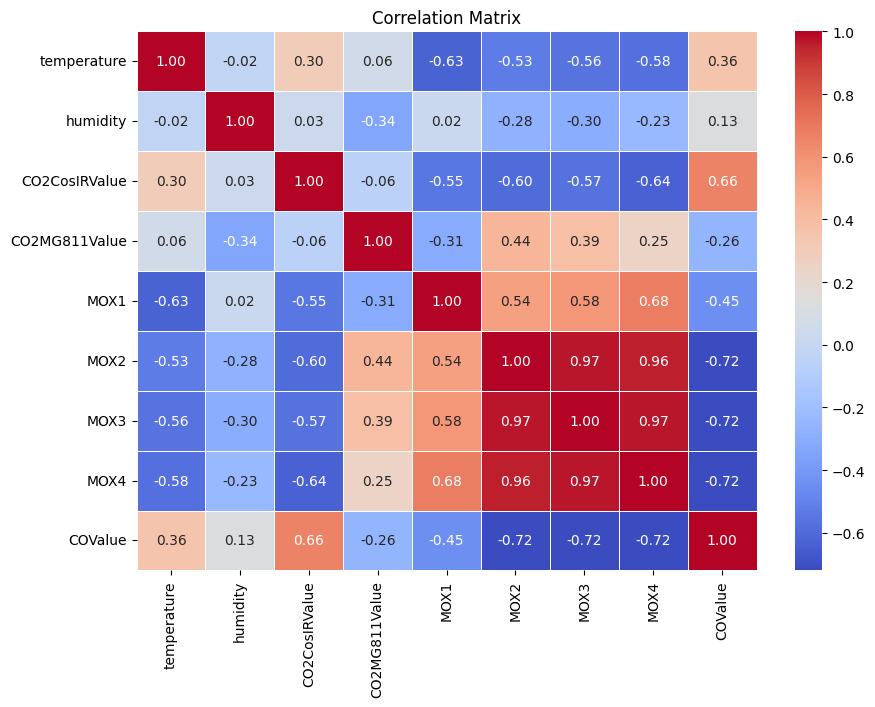

In [62]:
correlation_matrix = data_hour_agg[columns_features].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')

plt.show()

In [63]:
data_hour_agg.drop(["CO2CosIRValue", 'MOX3', 'MOX4'], axis=1, inplace=True)

# Обучение

In [ ]:
data_hour_agg["anomaly"] = data_hour_agg["anomaly"].astype("int")

In [68]:
data_hour_agg["hour"] = data_hour_agg.index.hour
data_hour_agg = data_hour_agg.dropna()
data_hour_agg

,temperature,humidity,CO2MG811Value,MOX1,MOX2,COValue,anomaly,hour
timestamp,,,,,,,,
2019-11-06 11:00:00,19.792464,51.985072,586.985507,508.275362,744.057971,112.362319,0,11
2019-11-06 12:00:00,19.533222,49.122222,617.844444,555.238889,776.822222,94.527778,0,12
2019-11-06 13:00:00,19.699111,51.239833,616.772222,530.872222,760.505556,95.533333,0,13
2019-11-06 14:00:00,20.202778,49.903167,618.461111,427.705556,757.966667,111.450000,0,14
2019-11-06 15:00:00,20.311944,50.692444,615.988889,385.505556,753.555556,107.855556,0,15
...,...,...,...,...,...,...,...,...
2020-02-13 07:00:00,20.275222,58.441167,518.155556,528.961111,703.366667,148.238889,1,7
2020-02-13 08:00:00,20.341500,58.252778,518.011111,530.033333,704.350000,149.438889,1,8
2020-02-13 09:00:00,20.396167,57.806222,518.072222,530.455556,705.305556,148.750000,1,9


In [69]:
# Классы не равномерны
data_hour_agg["anomaly"].value_counts()

0    1896
1     423
Name: anomaly, dtype: int64

In [70]:
features = data_hour_agg.drop("anomaly", axis=1)
target = data_hour_agg["anomaly"]

In [71]:
print(features.shape)
print(target.shape)

(2319, 7)
(2319,)


In [72]:
HOUR = ['hour']
NUMERIC = features.columns.to_list()
NUMERIC.remove('hour')
NUMERIC

['temperature', 'humidity', 'CO2MG811Value', 'MOX1', 'MOX2', 'COValue']

### LogisticRegression

In [73]:
# кодировка категориальных признаков и маштабирование численных
features_log_reg = features.copy()

col_transformer_log_reg = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        HOUR
    ),
    (
        StandardScaler(),
        NUMERIC
    ),
    remainder='passthrough')

In [74]:
%%time

model_log_reg = LogisticRegression(class_weight='balanced', random_state=42)

pipeline_log_reg = make_pipeline(col_transformer_log_reg, model_log_reg)

params_grid_log_reg = {'logisticregression__C': [0.001,0.01,0.1,1,10,100,1000]}
grid_log_reg = GridSearchCV(
    pipeline_log_reg,
    param_grid=params_grid_log_reg,
    scoring='f1',
    n_jobs=-1,
    verbose=1)

grid_log_reg.fit(features_log_reg, target)

best_model_log_reg = grid_log_reg.best_estimator_
best_parametrs_log_reg = grid_log_reg.best_params_
best_result_log_reg = grid_log_reg.best_score_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

CPU times: user 221 ms, sys: 152 ms, total: 373 ms
Wall time: 2.27 s


In [75]:
print(best_result_log_reg) # лучший результат модели
print(best_parametrs_log_reg) # лучшие параметры модели

0.8253451255217759
{'logisticregression__C': 0.1}


### RandomForest

In [76]:
# кодировка категориальных признаков и маштабирование численных
features_forest = features.copy()

col_transformer_forest = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        HOUR
    ),
    (
        StandardScaler(),
        NUMERIC
    ),
    remainder='passthrough')

In [77]:
%%time

model_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

pipeline_forest = make_pipeline(col_transformer_forest, model_forest)

params_grid_forest = {'randomforestclassifier__n_estimators': range(100, 250, 50),
                      'randomforestclassifier__max_depth': range(2, 15)}

grid_forest = GridSearchCV(
    pipeline_forest,
    param_grid=params_grid_forest,
    scoring='f1',
    n_jobs=-1,
    verbose=1)

grid_forest.fit(features_forest, target)

best_model_forest = grid_forest.best_estimator_
best_parametrs_forest = grid_forest.best_params_
best_result_forest = grid_forest.best_score_

Fitting 5 folds for each of 39 candidates, totalling 195 fits
CPU times: user 732 ms, sys: 23.4 ms, total: 756 ms
Wall time: 8.63 s


In [78]:
print(best_result_forest) # лучший результат модели
print(best_parametrs_forest) # лучшие параметры модели

0.7885874168658549
{'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 200}


### OneClassSVM

In [79]:
# кодировка категориальных признаков и маштабирование численных
features_svm = features.copy()

col_transformer_svm = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        HOUR
    ),
    (
        StandardScaler(),
        NUMERIC
    ),
    remainder='passthrough')


In [80]:
import numpy as np

In [81]:
%%time

model_svm = SVC()
# StandardScaler()
pipeline_svm = make_pipeline(col_transformer_svm, model_forest)

params_grid_svm = {'kernel': ['rbf', 'linear'],
                   'gamma': np.logspace(-3, 2, 6)}

grid_svm = GridSearchCV(
    model_svm,
    param_grid=params_grid_svm,
    scoring='f1',
    n_jobs=-1,
    verbose=1)

grid_svm.fit(features_svm, target)

best_model_svm = grid_svm.best_estimator_
best_parametrs_svm = grid_svm.best_params_
best_result_svm = grid_svm.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 470 ms, sys: 11.3 ms, total: 481 ms
Wall time: 2.84 s


In [82]:
print(best_result_svm) # лучший результат модели
print(best_parametrs_svm) # лучшие параметры модели

0.7510540810290548
{'gamma': 0.001, 'kernel': 'linear'}


## Сохранение лучших моделей

In [83]:
MODEL_PATH = "./"

In [84]:
import joblib

In [85]:
pickle.dump(best_model_log_reg, open(f"{MODEL_PATH}/log_reg_model.pkl", "wb"))
joblib.dump(best_model_forest, f"{MODEL_PATH}/forest_model.joblib", compress=0)
pickle.dump(best_model_svm, open(f"{MODEL_PATH}/svm_model.pkl", "wb"))